In [25]:
import subprocess

packages = ['geopandas', 'pandas', 'numpy', 'shapely', 'pyproj', 'fiona','rasterio','scipy']

for p in packages:
  subprocess.check_call(['pip', 'install', p])

#pip install -Uqq geopandas pandas numpy shapely pyproj fiona

import os
import shutil
import tempfile
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, box, mapping
from pyproj import CRS
import fiona
import requests
import json
import rasterio
from rasterio.mask import mask
from scipy.spatial import Voronoi

fiona.drvsupport.supported_drivers['KML'] = 'rw'

def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved as '{save_path}'.")
    else:
        print(f"Error occurred while downloading file from '{url}'.")
        
def get_metadata(attribute):
  curl_command = ["curl", "-H", "Metadata-Flavor: Google", f"http://metadata/computeMetadata/v1/instance/{attribute}"]
  result = subprocess.run(curl_command, capture_output=True, text=True)
  return result.stdout.strip()

def expand_to_gcps(focal_poly, gcps, gcp_cutoff=5, step_sz=30, base_buffer=100):
    focal_poly = focal_poly.buffer(base_buffer)
    count = sum(gcps.within(focal_poly.geometry.iloc[0]))
    
    if count < gcp_cutoff:
        while count < gcp_cutoff:
            focal_poly = focal_poly.buffer(step_sz)
            count = sum(gcps.within(focal_poly.geometry.iloc[0]))
    
    return focal_poly

def load_kml(path):
  df = gpd.GeoDataFrame()

  # iterate over layers
  for layer in fiona.listlayers(path):
      s = gpd.read_file(path, driver='KML', layer=layer)
      df = pd.concat([df, s], ignore_index=True)
  return df

def copy_to_gcs(local_file_path, bucket_name):
    command = ['gsutil', 'cp', local_file_path, 'gs://{}/'.format(bucket_name)]
    try:
        subprocess.run(command, check=True)
        print('File copied to Google Cloud Storage successfully.')
    except subprocess.CalledProcessError as e:
        print('Error occurred while copying the file to Google Cloud Storage:')
        print(e)

def filter_manifest(manifest, focal_poly, address_type='url'):
  focal_poly_ll = focal_poly.to_crs(epsg=4326)
  keepers = []
  for index, row in manifest.iterrows():
    point = Point(row['longitude'], row['latitude'])
    if point.within(focal_poly_ll.geometry.iloc[0]):  # only keep points within the polygon
            keepers.append(row[address_type])
  return keepers

def mask_to_gdf(gdf, raster_path, output_path):
    # Read the raster file
    src = rasterio.open(raster_path)

    # Reproject the GeoDataFrame to match the projection of the raster, if needed
    gdf = gdf.to_crs(src.crs)

    # Mask the raster using the GeoDataFrame's geometry
    out_image, out_transform = mask(src, gdf.geometry, crop=True)

    # Update the metadata of the cropped raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save the cropped raster to a new file
    with rasterio.open(output_path, 'w', dtype=src.dtypes[0], compress=src.compression,**out_meta) as dst:
        dst.write(out_image)

def process_images(batch, output_bucket, ortho_res, cutline, suffix):
   # Create a temporary directory
    temp_dir = tempfile.mkdtemp()

    # Create an 'images' subdirectory
    images_dir = os.path.join(temp_dir, 'images')
    os.mkdir(images_dir)

    for url in batch:
        try:
            subprocess.run(['wget', '-P', images_dir, url], check=True)
            print(f"File downloaded successfully from {url}")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred while downloading file from {url}:")
            print(e)

    # Execute OpenDroneMap Docker command
    docker_command = [
        "docker", "run", "--rm",
        "-v", "{}:/datasets/code".format(temp_dir),
        "opendronemap/odm", "--project-path", "/datasets",
        "--orthophoto-resolution", f"{ortho_res}",
        "--fast-orthophoto",
        "--force-gps"
    ]

    process = subprocess.run(docker_command, check=True)
    
    ortho = os.path.join(temp_dir,'odm_orthophoto/odm_orthophoto.tif')
    report = os.path.join(temp_dir,'odm_report/report.pdf')
    ortho_new = ortho.replace('.tif',f'_{suffix}.tif')
    report_new = report.replace('.pdf',f'_{suffix}.pdf')
    
    mask_to_gdf(cutline, ortho, ortho_new)
    os.rename(report, report_new)

    focal_files = [ortho_new, report_new]
    
    for f in focal_files:
        copy_to_gcs(f, output_bucket)
    
    # Cleanup: Remove temporary directory
    shutil.rmtree(temp_dir)

def stop_instance(instance_name):
    # Construct the gsutil command to stop the instance
    gsutil_command = f'gsutil compute instances stop {instance_name}'

    try:
        # Execute the gsutil command using subprocess
        subprocess.run(gsutil_command, shell=True, check=True)
        print(f'Successfully stopped instance: {instance_name}')
    except subprocess.CalledProcessError as e:
        print(f'Error stopping instance: {instance_name}')
        print(e)

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Source: https://gist.github.com/pv/8036995
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def generate_points(poly, num, seed=None):
    np.random.seed(seed)
    points = []
    minx, miny, maxx, maxy = poly.bounds
    while len(points) < num:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if (random_point.within(poly)):
            points.append(random_point)
    return [point.coords[0] for point in points]

def calculate_voronoi_complexity(poly, points):
    # compute Voronoi tesselation
    vor = Voronoi(points)
    
    # create finite Voronoi polygons
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    # construct the polygons and intersect with the original one
    voronoi_polygons = [poly.intersection(Polygon(vertices[region])) for region in regions]
    
    # return only the valid ones (completely inside the original polygon)
    valid_polygons = [p for p in voronoi_polygons if p.is_valid]

    # calculate the perimeter and areas of each valid polygon
    perimeters = [p.length for p in valid_polygons]
    areas = [p.area for p in valid_polygons]
    complexity = [x / y for x, y in zip(perimeters, areas)]
    
    return complexity, valid_polygons

def optimize_voronoi_complexity(poly, num, max_iterations=1000, learning_rate=0.1, seed=None):
    points = generate_points(poly, num, seed)
    np.random.seed(seed)
    mns = [] # to store complexity means at each iteration
    
    for i in range(max_iterations):
        complexity, polygons = calculate_voronoi_complexity(poly, points)
        mn = np.mean(complexity)
        mns.append(mn) # append current std dev to the list

        # randomly select a point
        point_idx = np.random.randint(0, len(points))
        current_point = Point(points[point_idx])
        
        # Compute gradients by trying small movements in each direction
        min_mn = mn
        min_mn_direction = None
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            new_point = Point(current_point.x + dx * learning_rate, current_point.y + dy * learning_rate)
            new_points = points.copy()
            new_points[point_idx] = (new_point.x, new_point.y)
            
            new_complexity, _ = calculate_voronoi_complexity(poly, new_points)
            new_mn = np.mean(new_complexity)
            
            if new_mn < min_mn:
                min_mn = new_mn
                min_mn_direction = (dx, dy)
        
        # If we found a direction that decreases the mean complexity, move the point
        if min_mn_direction is not None:
            dx, dy = min_mn_direction
            points[point_idx] = (current_point.x + dx * learning_rate, current_point.y + dy * learning_rate)
    
    return polygons, mns

temp_work = tempfile.mkdtemp()
os.chdir(temp_work)

#later these will be updated to gcloud metadata queries:
branch = 'voronoi'
survey = '230601_spurgepoly'
array_idx = 0
config_url = f'https://raw.githubusercontent.com/samsoe/mpg_aerial_survey/{branch}/surveys/{survey}/config_file.json'
instance_name = f'odm-array-{array_idx}' #name of instance inferred from index

#array_idx = int(get_metadata('array_idx')) #dynamic production version
#config_url = get_metadata('config_url')#dynamic production version

config_file = os.path.basename(config_url)
download_file(config_url, config_file)

with open(config_file, 'r') as json_file:
    # Load the JSON data into a Python object
    config = json.load(json_file)

gcp_res = str(200)
#gcp_res = str(config['gcp_res'])
gcp_grid_url = f'https://raw.githubusercontent.com/samsoe/mpg_aerial_survey/{branch}/gcp_kmls/upland_gcps_{gcp_res}m.kml'

survey_res = config['survey_res']
compute_array_sz = config['compute_array_sz']
flight_plan_url = config['flight_plan_url']
photo_manifest_url = config['photo_manifest_url']
output_bucket =  config['output_bucket']
gcp_editor_url = config['gcp_editor_url']

gcp_grid = os.path.basename(gcp_grid_url)
flight_plan = os.path.basename(flight_plan_url)
photo_manifest = os.path.basename(photo_manifest_url)

download_file(gcp_grid_url, gcp_grid)
download_file(flight_plan_url, flight_plan)
download_file(photo_manifest_url, photo_manifest)

flight_roi = load_kml(flight_plan)
gcps = load_kml(gcp_grid)

crs_source = CRS.from_epsg(4326)
crs_target = CRS.from_epsg(26911)

# Set the source CRS of the GeoDataFrame
flight_roi.crs = crs_source
gcps.crs = crs_source

# Reproject the GeoDataFrame to the target CRS
flight_projected_src = flight_roi.to_crs(crs_target)
gcps_projected_src = gcps.to_crs(crs_target)

gcps_flight = gpd.sjoin(gcps_projected_src, flight_projected_src, how='inner', op='within')

parts, means = optimize_voronoi_complexity(flight_projected_src.geometry[0], compute_array_sz, 
                                         learning_rate=30, max_iterations=1000, seed=0)

base_poly = gpd.GeoDataFrame(geometry=[parts[array_idx]], crs = 26911)
buffered_poly = expand_to_gcps(base_poly, gcps_flight, step_sz=30)

manifest_df = pd.read_csv(photo_manifest)

target_photos = filter_manifest(manifest_df, buffered_poly)
print(target_photos)

File downloaded successfully and saved as 'config_file.json'.
File downloaded successfully and saved as 'upland_gcps_200m.kml'.
File downloaded successfully and saved as 'flightplan.kml'.
File downloaded successfully and saved as 'manifest.csv'.


/opt/miniconda3/envs/ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


['https://storage.googleapis.com/mpg-aerial-survey/surveys/230601_spurgepoly/data_collection/m3m/DJI_20230601143937_0158_D.JPG', 'https://storage.googleapis.com/mpg-aerial-survey/surveys/230601_spurgepoly/data_collection/m3m/DJI_20230601143938_0159_D.JPG', 'https://storage.googleapis.com/mpg-aerial-survey/surveys/230601_spurgepoly/data_collection/m3m/DJI_20230601143939_0160_D.JPG', 'https://storage.googleapis.com/mpg-aerial-survey/surveys/230601_spurgepoly/data_collection/m3m/DJI_20230601143940_0161_D.JPG', 'https://storage.googleapis.com/mpg-aerial-survey/surveys/230601_spurgepoly/data_collection/m3m/DJI_20230601143940_0162_D.JPG', 'https://storage.googleapis.com/mpg-aerial-survey/surveys/230601_spurgepoly/data_collection/m3m/DJI_20230601143941_0163_D.JPG', 'https://storage.googleapis.com/mpg-aerial-survey/surveys/230601_spurgepoly/data_collection/m3m/DJI_20230601143942_0164_D.JPG', 'https://storage.googleapis.com/mpg-aerial-survey/surveys/230601_spurgepoly/data_collection/m3m/DJI_202

885

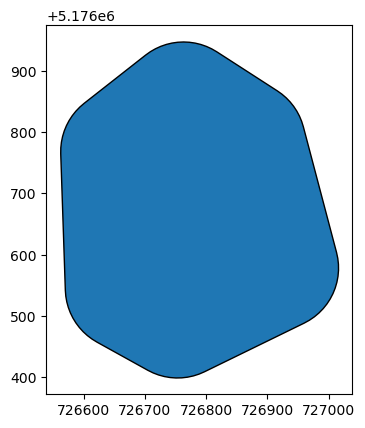

In [27]:
buffered_poly.plot(edgecolor='black')
len(target_photos)

In [ ]:
# process_images(batch=target_photos, output_bucket=output_bucket, ortho_res=survey_res, cutline=base_poly ,suffix=array_idx)

# shutil.rmtree(temp_work)